In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import linalg as LA

import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.spatial import distance_matrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Implementation

In [38]:
def D(data):
    return distance_matrix(data,data)
def invert_diagonal(diag_matrix):
    ret = np.zeros(diag_matrix.shape)
    for i in range(diag_matrix.shape[0]):
        ret[i,i] = 1/diag_matrix[i,i]
    return ret
def invert_root_diagonal(diag_matrix):
    ret = np.zeros(diag_matrix.shape)
    for i in range(diag_matrix.shape[0]):
        ret[i,i] = 1/np.sqrt(diag_matrix[i,i])
    return ret

def diffusion_map(dataset, amount_of_vectors = 5):
    '''
    The diffusion Map algorithm
    :param dataset: The data for which the diffusion map algorithm is to be calculated
    :param amount_of_vectors: How many vectors are supposed to be returned (Largest ones, ascending order)
    :return: eigenvalues,eigenvectors in ascending order
    '''
    #First get the Size of the dataset
    N = len(dataset)
    #Create the distance matrix
    D_matrix = D(dataset)
    #Calculate epsilon (5% of the largest distance)
    epsilon = 0.05 * D_matrix.max()
    #Calculate the kernel as described in the exercise sheet
    #Note: Very numerically sensitive
    W = np.exp(-(np.square(D_matrix)/epsilon))
    #Create the diagonal matrix P for normalization
    P  = np.zeros(W.shape)
    for i in range(N):
        for j in range(N):
            P[i,i] = P[i,i] + W[i,j]
    #Alternatively create it like this_
    #P = np.diag(np.sum(W,axis=0))
    #But this gives different results? (Numerical instability probably)
    
    #Calculate the inverse of P
    #Note, because P is a diagonal matrix, the inverse is just a matrix where each diagonal element is 1 divided by the original element
    P_inv = invert_diagonal(P)
    #Alternatively can be calculated like this, but this gives different results? (Numerical instability probably)
    #P_inv = LA.inv(P)
    
    #Calculate K by normalizing W with P_inv
    K = P_inv @ W @ P_inv
    
    #Calculate Q the same way P was calculated
    Q = np.diag(np.sum(K,axis=0))
    #Q^-1/2 is the same as taking the square root of each diagonal element and calculating 1 divided by that value
    #This is again very numerically instable and can give varying results based on the way how one calculates it
    Q_rootinv = LA.inv(np.sqrt(Q))
    
    #Calculate T_hat (Here I just use T) by normalizing K with Q_rootinv
    T = Q_rootinv @ K @ Q_rootinv
    
    #Calculate the eigenvalues and eigenvectors of T, sorted in ascending order(!) 
    eigenvalues,eigenvectors = eigh(T,subset_by_index = [N-amount_of_vectors,N-1])
    
    #Calculate the final eigenvalues and eigenvectors as described in the exercise sheet
    lambda_l_squared = np.sqrt(np.power(eigenvalues,1/epsilon))
    theta_l = Q_rootinv @ eigenvectors
    
    return lambda_l_squared,theta_l

# Part One

## Creating the dataset

In [39]:
dataset = []
tks = []
N = 1000
for i in range(1,N+1):
    tk = (2*np.pi*i)/(N+1)
    tks.append(tk)
    xk = [np.cos(tk),np.sin(tk)]
    dataset.append(xk)

## Plot the data

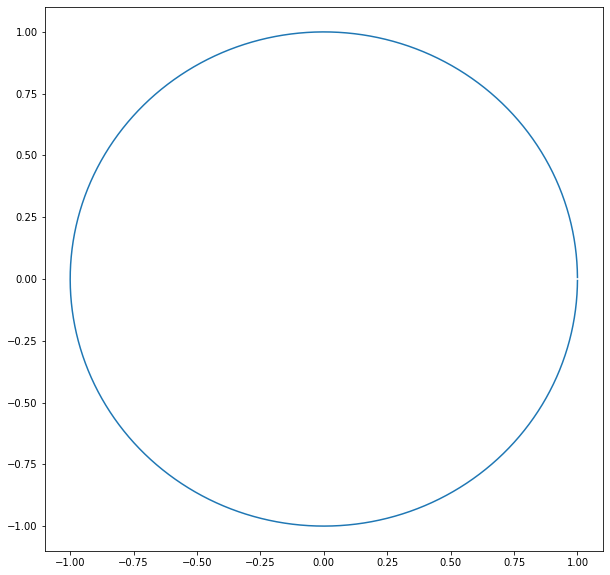

In [40]:
plt.rcParams["figure.figsize"]=10,10
#plt.rcParams['figure.dpi'] = 10

fig = plt.figure()
ax = plt.axes()
X,Y = zip(*dataset)
ax.plot(X,Y)
plt.show()

# Calculate the diffusion map

In [64]:
eigenvalues,eigenvectors = diffusion_map(dataset)

## Plot the eigenfunctions

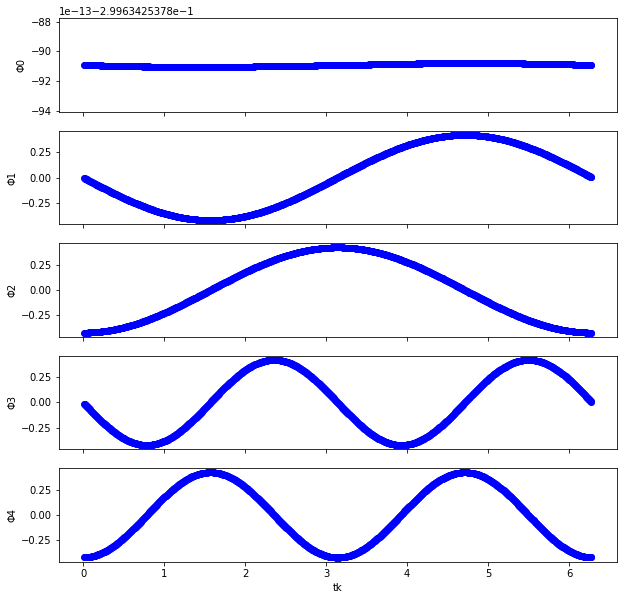

In [65]:
plt.rcParams["figure.figsize"]=10,10
fig, ax = plt.subplots(5,sharex=True)
steps = 1000
plt.xlabel('tk')

for z in reversed(range(5)):
    ax[4-z].set_ylabel('\u03A6'+str(4-z))
    for i in range(1,steps):
        ax[4-z].plot(tks[i], eigenvectors[i][z],'bo')
plt.show()

# Part Two: Swiss roll

## Get the data

In [43]:
swiss_roll,stuff = sklearn.datasets.make_swiss_roll(n_samples=5000, noise=0.0, random_state=None)
print(swiss_roll)

## Calculate the diffusion map

In [44]:
eigenvalues,eigenvectors = diffusion_map(swiss_roll,amount_of_vectors = 11)

## Plot the eigenfunctions

8
7
6
5
4
3
2
1
0


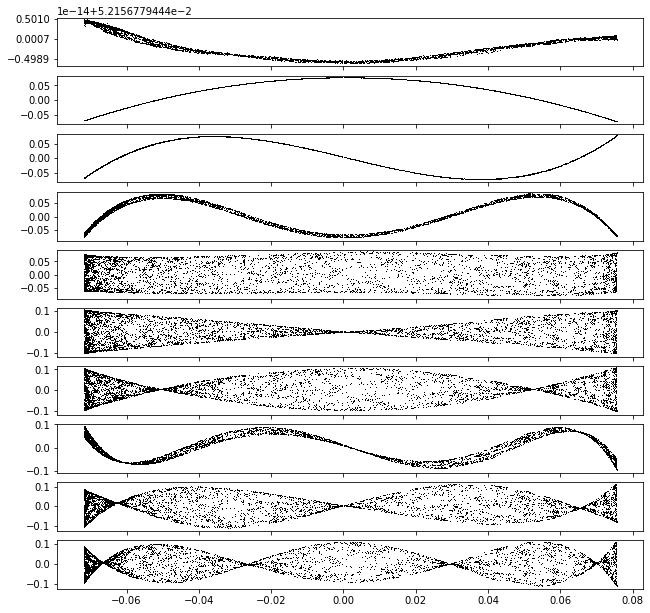

In [45]:
fig, ax = plt.subplots(10,sharex=True)
fig.set_size_inches(10.5, 10.5)
steps = 5000
X = [0,0,0,0,0,0,0,0,0,0,0]
X[0],X[1],X[2],X[3],X[4],X[5],X[6],X[7],X[8],X[9],X[10]= zip(*eigenvectors)
for z in reversed(range(0,9)):
    print(z)
    ax[1+8-z].plot(X[9], X[z],',k')
ax[0].plot(X[9],X[10],',k')
plt.show()

## Part two Bonus

## Imports for the bonus

In [56]:
import copy

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import sklearn.manifold as manifold
from sklearn.datasets import make_s_curve, make_swiss_roll
from sklearn.decomposition import PCA
import datafold

import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.dynfold import LocalRegressionSelection
from datafold.utils.plot import plot_pairwise_eigenvector

## Plot the Swiss roll data

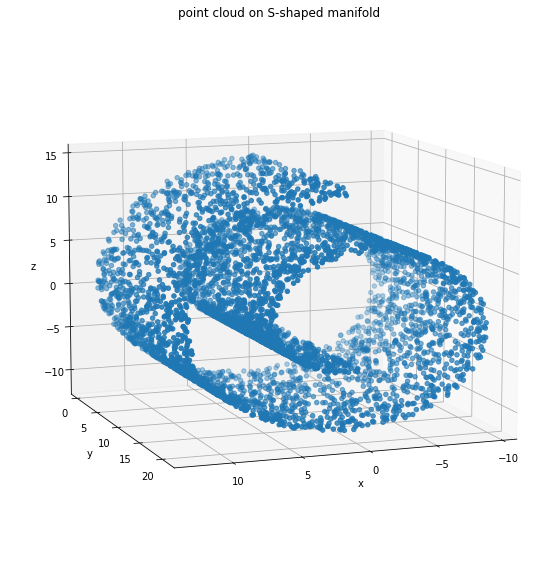

In [57]:
nr_samples = 5000

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
X,Y,Z = zip(*swiss_roll)
ax.scatter(X,Y,Z)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("point cloud on S-shaped manifold")
ax.view_init(10, 70)

## Set up the calculation

In [58]:
X_pcm = pfold.PCManifold(swiss_roll)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=0.5176747535880026, cut-off=3.088028718300529


## Calculate the diffusion map

In [59]:
dmap = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
    n_eigenpairs=11,
    dist_kwargs=dict(cut_off=X_pcm.cut_off),
)
dmap = dmap.fit(X_pcm)

## Plot the eigenfunctions

(5000, 11)


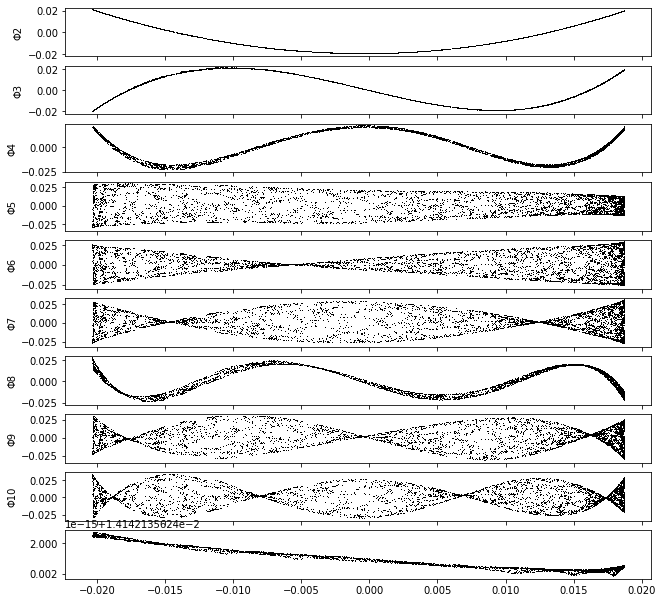

In [62]:
fig, ax = plt.subplots(10,sharex=True)
fig.set_size_inches(10.5, 10.5)


evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_
print(evecs.shape)
X = [0,0,0,0,0,0,0,0,0,0,0]
X[0],X[1],X[2],X[3],X[4],X[5],X[6],X[7],X[8],X[9],X[10]= zip(*evecs)
for z in range(2,11):
    ax[z-2].set_ylabel('\u03A6'+str(z))
    ax[z-2].plot(X[1], X[z],',k')
ax[9].plot(X[1],X[0],',k')
plt.show()

# Part Three

## Get the data

In [67]:
data = np.genfromtxt("datasets/pca/data_DMAP_PCA_vadere.txt", dtype='double')
print("Shape =", data.shape)

Shape = (1000, 30)


## Calculate the diffusion map

In [68]:
eigenvalues,eigenvectors = diffusion_map(data,amount_of_vectors = 6)

## Plot the eigenfunctions

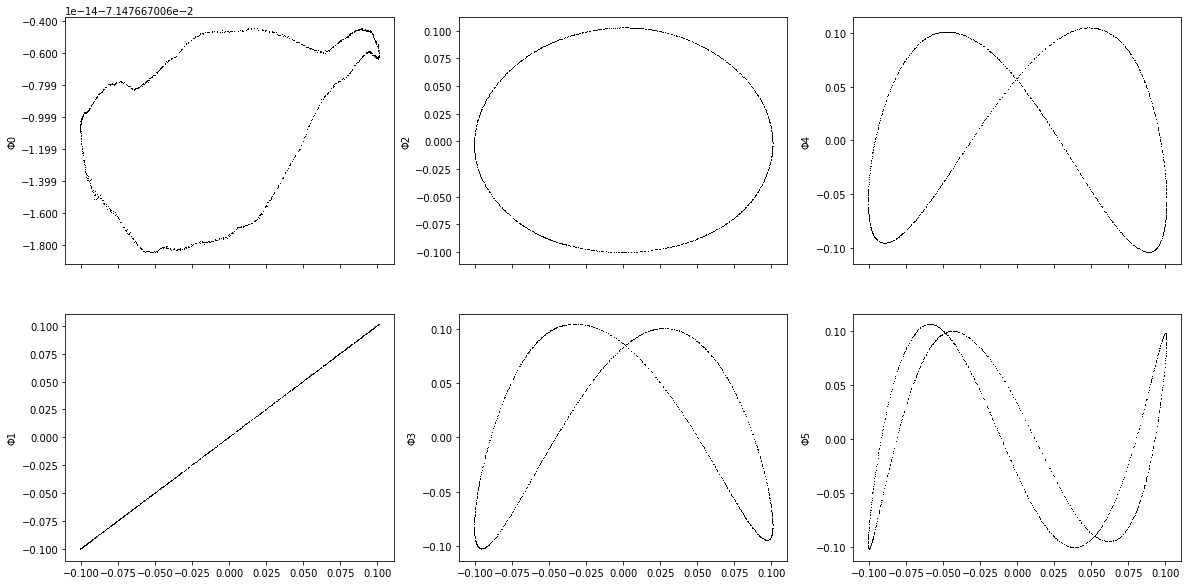

In [69]:
plt.rcParams["figure.figsize"]=20,10
fig, ax = plt.subplots(2,3,sharex=True)
X = [0,0,0,0,0,0]
X[0],X[1],X[2],X[3],X[4],X[5]= zip(*eigenvectors)

for i in range(2):
    for j in range(3):
        ax[i][j].set_ylabel('\u03A6'+str((2*j+i)))
        ax[i,j].plot(X[4],X[5-(j*2+i)],',k')

plt.show()